In [121]:
import json
import pandas as pd
import seaborn as sns
import numpy as np

Process raw json data into datamframes

In [122]:
devices_f = open("devices.txt")
num_to_animal = json.loads(devices_f.read())

In [123]:
logs_f = open("logs.txt")
logs = logs_f.readlines()
logs = [line for line in logs if line!="\n"]

In [124]:
logs_dict = [json.loads(line) for line in logs]
logs_dict = [line for line in logs_dict if type(line)!=dict]

data = []
for item in logs_dict:
    data = data + item

In [125]:
data_by_type = {"location":{"timestamp":[],"data":[],"animal_num":[]}, \
                "pulseOxygen":{"timestamp":[],"data":[],"animal_num":[]}, \
                "temperature":{"timestamp":[],"data":[],"animal_num":[]}, \
                "humidity":{"timestamp":[],"data":[],"animal_num":[]}}

for entry in data:
    animal_num = entry['deviceId'].split("_")[1]
    animal = num_to_animal[animal_num]
    input_data = entry['sensors'][0]['input']
    data_type = list(input_data.keys())[0]
    if data_type in data_by_type:
        cur_data = data_by_type[data_type]
        cur_data["timestamp"].append(entry["timestamp"])
        cur_data["animal_num"].append(animal_num)
        cur_data["data"].append(input_data[data_type])
    

In [254]:
def create_dataframe(data, data_type):
    cur_data = data[data_type]
    df = pd.DataFrame(data={"timestamp":cur_data["timestamp"],\
                       data_type:cur_data["data"], \
                       "animal_num":cur_data["animal_num"]}).sort_values(by=["animal_num","timestamp"])
    return df

In [255]:
zebra_num = [str(i) for i in range(18,33)]
elephant_num = [str(i) for i in range(0,12)]
temperature_data = create_dataframe(data_by_type, "temperature")
humidity_data = create_dataframe(data_by_type, "humidity")
temperature_zebra = temperature_data[temperature_data["animal_num"].isin(zebra_num)]
humidity_zebra = humidity_data[humidity_data["animal_num"].isin(zebra_num)]

Plotting

Text(0.5, 1.0, 'Pulse distribution in Zebras')

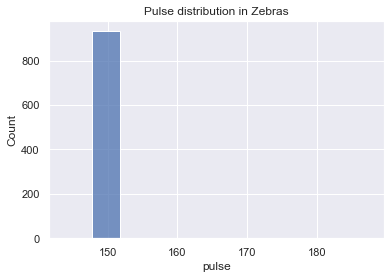

In [264]:
g_pulse = sns.histplot(data=vital_data, x="pulse")
g_pulse.set_title('Pulse distribution in Zebras')

Text(0.5, 1.0, 'Oxygen distribution in Zebras')

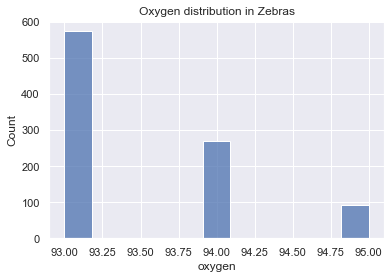

In [265]:
g_oxygen = sns.histplot(data=vital_data, x="oxygen")
g_oxygen.set_title('Oxygen distribution in Zebras')

Get Location dataframe

In [242]:
cur_data = data_by_type["location"]
location_array = np.array(data_by_type["location"]["data"])
x = location_array[:,0]
y = location_array[:,1]
all_location_data = pd.DataFrame(data={"timestamp":cur_data["timestamp"],\
                   "x":x, \
                   "y":y, \
                   "animal_num":cur_data["animal_num"]}).sort_values(by=["animal_num","timestamp"])
location_data = all_location_data[all_location_data["animal_num"].isin(zebra_num)]

Get vital dataframe

In [129]:
cur_data = data_by_type["pulseOxygen"]
location_array = np.array(data_by_type["pulseOxygen"]["data"])
pulse = location_array[:,0]
oxygen = location_array[:,1]
all_vital_data = pd.DataFrame(data={"timestamp":cur_data["timestamp"],\
                   "pulse":pulse, \
                   "oxygen":oxygen, \
                   "animal_num":cur_data["animal_num"]}).sort_values(by=["animal_num","timestamp"])
vital_data = all_vital_data[all_vital_data["animal_num"].isin(zebra_num)]


Text(0.5, 1.1, 'Temperature data by each zebra')

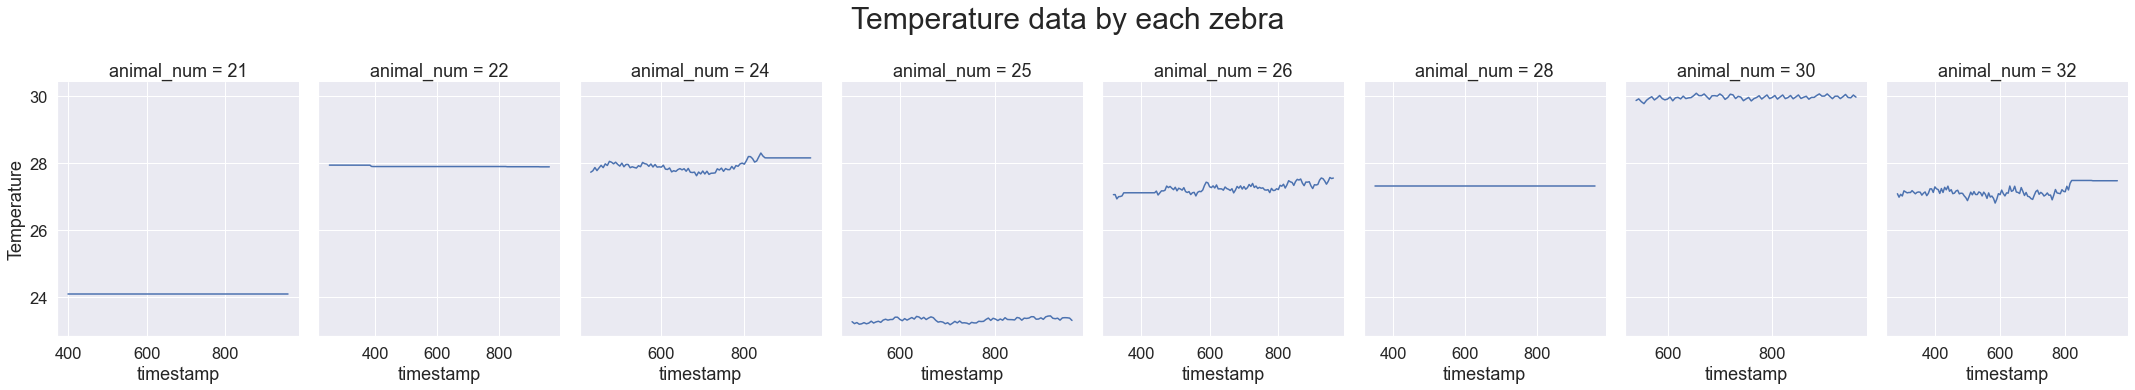

In [130]:
sns.set(font_scale=1.5)
g_temperature = sns.relplot(
    data=temperature_zebra,
    x="timestamp", y="data",
    col="animal_num",
    kind="line",
    height=5, aspect=.75, facet_kws=dict(sharex=False)
)
g_temperature.set_ylabels("Temperature")
g_temperature.fig.suptitle('Temperature data by each zebra', y=1.1, fontsize=30)

Text(0.5, 1.1, 'Pulse data by each zebra')

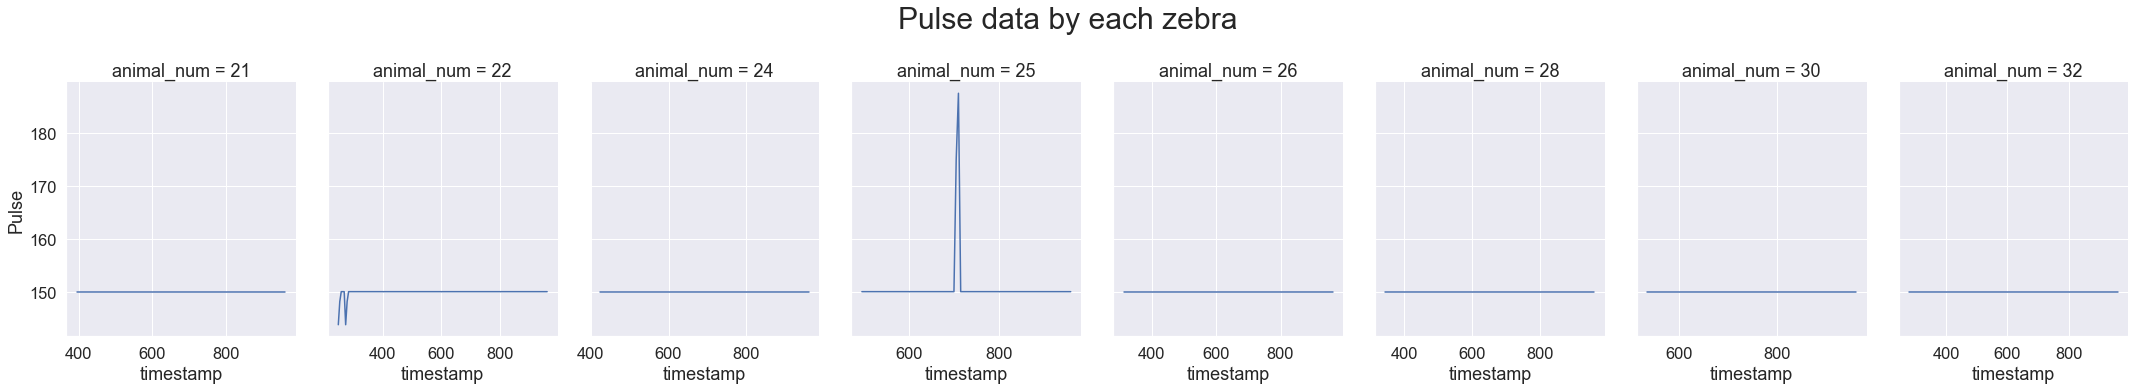

In [98]:
g_pulse = sns.relplot(
    data=vital_data,
    x="timestamp", y="pulse",
    col="animal_num",
    kind="line",
    height=5, aspect=.75, facet_kws=dict(sharex=False)
)
g_pulse.set_ylabels("Pulse")
g_pulse.fig.suptitle('Pulse data by each zebra', y=1.1, fontsize=30)

Text(0.5, 1.1, 'Oxygen data by each zebra')

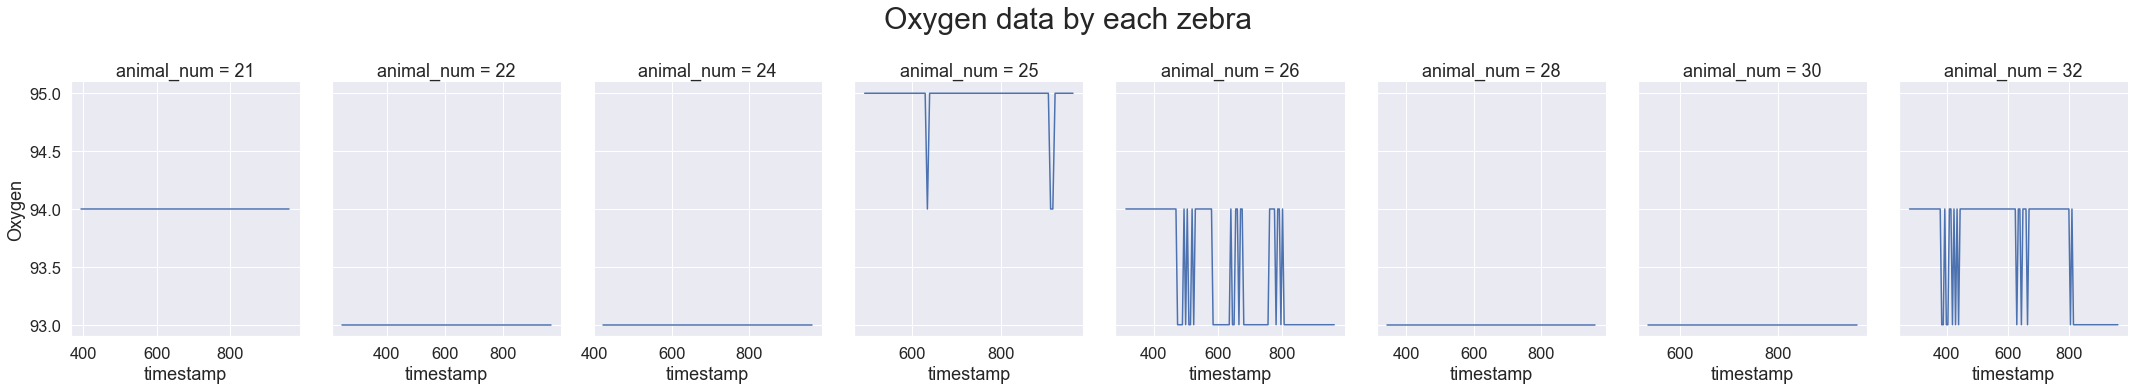

In [101]:
g_oxygen = sns.relplot(
    data=vital_data,
    x="timestamp", y="oxygen",
    col="animal_num",
    kind="line",
    height=5, aspect=.75, facet_kws=dict(sharex=False)
)
g_oxygen.set_ylabels("Oxygen")
g_oxygen.fig.suptitle('Oxygen data by each zebra', y=1.1, fontsize=30)

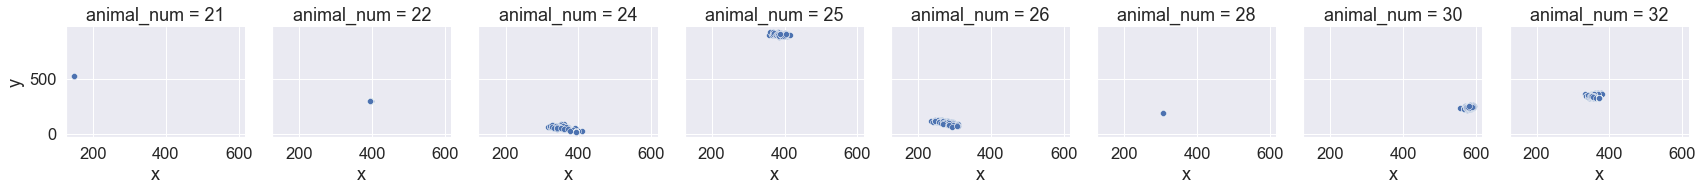

In [86]:
g = sns.FacetGrid(location_data, col="animal_num")
g.map(sns.scatterplot, "x", "y")


In [245]:
def conditions(s):
    if s['animal_num'] in zebra_num:
        return 'zebra'
    elif s['animal_num'] in elephant_num:
        return 'elephant'
    else:
        return 'lion'

all_location_data['animal_type'] = all_location_data.apply(conditions, axis=1)


In [225]:
def calculate_speed(gps_data, timestamp):
    gps_array = np.array(gps_data)
    prev_gps_array = np.vstack([gps_array[0,:], gps_array[:-1,:]])[1:,:]
    gps_array = gps_array[1:,:]
    timestamp_array = np.array(timestamp)
    prev_timestamp_array = np.insert(timestamp_array[:-1], 0, timestamp_array[0], axis=0)[1:]
    timestamp_array = timestamp_array[1:]
    squared = (gps_array-prev_gps_array)**2
    return np.sqrt(squared[:, 0]+squared[:, 1])

In [236]:
speed_data = create_dataframe(data_by_type, "location")
zebra_speed_data = speed_data[speed_data["animal_num"].isin(zebra_num)]
zebra_num_prime = list(set(zebra_speed_data["animal_num"].to_list()))
df_list = []
for num in zebra_num_prime:
    cur_df = zebra_speed_data[zebra_speed_data["animal_num"]==num]
    gps = cur_df["data"].to_list()
    timestamp = cur_df["timestamp"].to_list()
    cur_df = cur_df.iloc[1: , :]
    cur_df["speed"] = calculate_speed(gps, timestamp)
    df_list.append(cur_df)
speed_df = pd.concat(df_list)

Text(0.5, 1.0, 'CDF of Zebra speed')

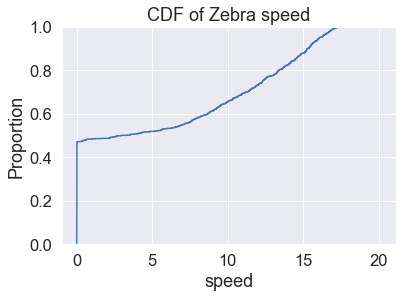

In [239]:
g_speed = sns.ecdfplot(data=speed_df, x="speed")
g_speed.set_title('CDF of Zebra speed')

In [217]:
gps_array = np.array(gps_data)
prev_gps_array = np.vstack([gps_array[0,:], gps_array[:-1,:]])[1:,:]
gps_array = gps_array[1:,:]
timestamp_array = np.array(timestamp)
prev_timestamp_array = np.insert(timestamp_array[:-1], 0, timestamp_array[0], axis=0)[1:]
timestamp_array = timestamp_array[1:]
squared = (gps_array-prev_gps_array)**2
return np.sqrt(squared[:, 0]+squared[:, 1])

Text(0.5, 1.0, 'GPS by each zebra')

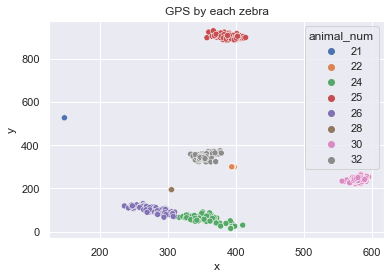

In [109]:
# q5 zebra pairs
sns.set(font_scale=1)
g_pairs = sns.scatterplot(data=location_data, x="x", y="y", hue='animal_num')
g_pairs.set_title('GPS by each zebra')

It seems that zebras have friends that often moves together with them. In our sample, zebra #18 and #22, zebra #32 and #31, zebra #20 and #26 are good friends, judging from the GPS data.

Text(0.5, 1.0, 'Movement by each type of animal')

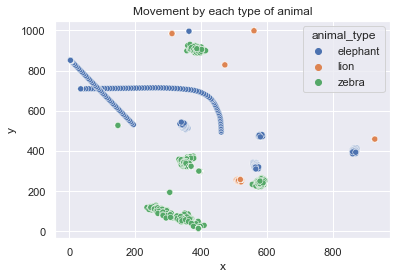

In [246]:
# q6
g_gps = sns.set(font_scale=1)
g_gps = sns.scatterplot(data=all_location_data, x="x", y="y", hue='animal_type')
g_gps.set_title('Movement by each type of animal')

Text(0.5, 1.0, 'Humidity level in GPS location ')

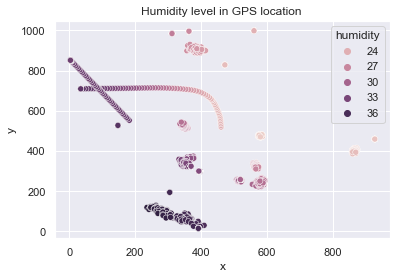

In [275]:
gps_humidity = pd.merge(all_location_data, humidity_data, on=['timestamp','animal_num'])
g_gps_humidity = sns.set(font_scale=1)
g_gps_humidity = sns.scatterplot(data=gps_humidity, x="x", y="y", hue='humidity')
g_gps_humidity.set_title('Humidity level in GPS location ')

Text(0.5, 1.0, 'Temperature in GPS location ')

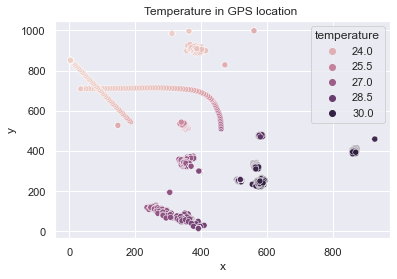

In [279]:
gps_temperature = pd.merge(all_location_data, temperature_data, on=['timestamp','animal_num'])
g_gps_temp = sns.set(font_scale=1)
g_gps_temp = sns.scatterplot(data=gps_temperature, x="x", y="y", hue='temperature')
g_gps_temp.set_title('Temperature in GPS location ')